# Overview
- Plug in parameters in parameter box, can run simulations immediately
    - Minimal use case: Run through section titled "Simulation with Parameters Chosen Above", skipping optional section if desired
    - Have to set "parallelized = False" to skip optional section
- Script meant to calculate error rates given sample skewing and barcode loss, in a generalizable way 
    - Perfect encoding written as lossless discrete encoder
    - Barcode loss modeled in a lossy discrete encoder
    - Sample skewing modeled in a lossless continuous encoder
    - Both barcode loss and sample skewing modeled in a lossy continuous encoder
- Have the option to run in a parallelized manner, for faster simulations
    - Goes from ~3 minutes to <1 minute for 1000 iterations with b=100,000, m = 10,000, m2 =10 on MacBook Pro

# Approach
## Modularization
Break into many transformations:

- Module 1: Patient samples viral load -> RT-LAMP molecules -> PCR molecules -> Gets pooled into sequencing
- Module 2: Sequencing reads -> thresholded to produce binary output
- Module 3: Binary output (0 or 1 for each barcode) -> Naive decoder for k' out of k. 

Initial focus is on last two modules, modeling the first module requires experimental data.

## Module 2 Model

Currently, molecules to be sequenced are modeled as:
- having amplified initial viral titer loads, log normal distribution with mean = 4.5, std = 3
- having saturating amplification functions, normalizing initial viral titer loads, normal distribution with mean 10000, std 1000

To go from post-PCR molecules to binary output:
- Fractional abundance for each barcode calculated by dividing by total number of molecules for a subbatch is computed
- If fractional abundance for a barcode * total good reads per subbatch > threshold, 1. Otherwise, 0. 



## To Do
- Characterize real transformations for module 1 (experimentally)
- Implement possibility for some people to have extra barcodes/less than expected due to liquid handling error
- Build a heatmap for FNPs/FPPs dependent on parameters for distribution of post-PCR molecules (mean, std)

In [1]:
#Check for/install dependencies, may need to restart kernel after
%pip install --user tqdm
%pip install --user multiprocess

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
#Import useful general  libraries
import numpy as np
import random
from random import seed
from random import randint
from tqdm.notebook import tnrange,tqdm_notebook, tqdm

#Packages for data analysis/stats
import pandas as pd
from scipy import stats
from sklearn.metrics import roc_auc_score, confusion_matrix

#Packages for plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

In [3]:
#General parameters 
prob = 0.01 #Percent of population infected
m = 10000 #Number of barcode 1s
m2 = 10 #Number of barcode 2s
b = 100000 #Number of patient samples per batch
k = 5 #Number of barcode 1s per patient sample
kprime = 3 #Number of barcode 1s required to call sample positive
scenario = 2 #Either 1 or 2, for the two scenarios described in the text
b2 = int(b/m2) #Number of patient samples per subbatch (with a rounding error)
n = int(np.ceil(b2*prob)) #Number of positive samples per subbatch (with a rounding error)
encoderchoice = 1 #Which encoder to use - 0 is discrete, 1 is discrete lossy, 2 is continuous, 3 is continuous lossy
iters = 1000 #Number of iterations to run things
parallelized = True #Parallelized (True) or non-parallized computation (False) [OPTIONAL]

#Parameters for barcode loss (discretelossyencoder, continuouslossyencoder)
dsynth = 0.01 #Proportion of barcode 1s that always fail
dstoch = 0.05 #Proportion of stochastic barcode 1 failure

#Parameters for sample skewing (continuouslosslessencoder, continuouslossyencoder)
setting = "Amp" #Either "Amp" or "Sat" describing models Amplified and Saturated respectively
mean = 4.5 #10000 #Mean of distribution of molecules
std = 3 #1000 #Standard deviation of distribution of molecules

#Parameters for read thresholding (thresholdcontinuous)
totalreads = 2*(10**8) #Reads per illumina run
readspersubbatch = totalreads/m2 #Reads per subbatch
propnoise = 0.1 #Proportion of reads that are junk
goodreads = int(np.ceil((1-propnoise)*readspersubbatch)) #Number of good reads per subbatch (with a rounding error)
threshold = 200 #Reads required to call a sample positive

# Helper Functions

In [4]:
#Functions for encoding from patient vector to barcode vector (continuous or discrete)
#All functions run in O(b2) time with O(m) memory (assuming b2 >= m)

def discretelosslessencoder(truth, m, k, scenario):
    '''
    Function takes np array of which patient samples are pos/neg and returns np array of which barcodes are pos/neg
    Hashing/assignment here is approximated by a RNG, being kept track of by patient sample index = seed
    
    Inputs:
        truth - ground truth matrix of patient samples (1 x b2), n of which are 1
        m - number of barcode 1s
        k - number of barcode 1s per patient sample
        scenario - either 1 or 2, describes which scenario chosen
    
    Outputs:
        barcodes - array (1 x m), 0 if negative, 1 if positive
    '''
    #Initialize barcode matrix
    barcodes = np.zeros((1, m)).astype(int)
    
    #Iterate through samples in truth and set corresponding barcodes to 1
    (truth1, truth2) = truth.shape
    for samp in range(truth2):
        if truth[0, samp] == 1: #If sample was positive
            seed(samp) #Set seed to RNG as sample index
            for bc in range(k):
                if scenario == 1:
                    bcindex = samp #Generate barcode index for scenario 1
                elif scenario == 2:
                    bcindex = randint(0, m-1) #Generate barcode index for scenario 2
                    randomprob = random.random() #For consistent hashes with lossy encoder
                barcodes[0, bcindex]=1 #Set barcode to 1            
    
    #Return final vector
    return barcodes

def discretelossyencoder(truth, m, k, scenario, dsynth, dstoch):
    '''
    Function takes np array of which patient samples are pos/neg and returns np array of which barcodes are pos/neg
    Hashing/assignment here is approximated by a RNG, being kept track of by patient sample index = seed
    Includes error where some barcodes always fail and some barcodes stochastically fail
    
    Inputs:
        truth - ground truth matrix of patient samples (1 x b2), n of which are 1
        m - number of barcode 1s
        k - number of barcode 1s per patient sample
        scenario - either 1 or 2, describes which scenario chosen
        dsynth - proportion of barcode 1s that always fail
        dstoch - proportion of stochastic barcode 1 failure
    
    Outputs:
        barcodes - array (1 x m), 0 if negative, 1 if positive
    '''
    #Initialize barcode matrix
    barcodes = np.zeros((1, m)).astype(int)
    
    #Iterate through samples in truth and set corresponding barcodes to 1, accounting for dstoch
    (truth1, truth2) = truth.shape
    for samp in range(truth2):
        if truth[0, samp] == 1: #If sample was positive
            seed(samp) #Set seed to RNG as sample index
            for bc in range(k):
                if scenario == 1:
                    bcindex = samp #Generate barcode index for scenario 1
                elif scenario == 2:
                    bcindex = randint(0, m-1) #Generate barcode index for scenario 2
                randomprob = random.random() #For consistent hashes with lossy encoder
                if randomprob >= dstoch: #Fails dstoch proportion of the time
                    barcodes[0, bcindex]=1 #Set barcode to 1         
    
    #Now, we deal with dsynth
    numzeros = int(np.ceil(m*dsynth)) #Calculate number of barcodes that always fail (with a rounding error)
    index_list = [] #Generate indices that should be 0
    while len(index_list) < numzeros:
        random_index = randint(0, m-1)
        if random_index not in index_list:
            index_list.append(random_index)
    for position in index_list: #Set those indices to 0
        barcodes[0, position] = 0
                
    #Return final vector
    return barcodes

def continuouslosslessencoder(truth, m, k, scenario, setting, mean, std):
    '''
    Function takes np array of which patient samples are pos/neg and returns np array of barcode counts
    Hashing/assignment here is approximated by a RNG, being kept track of by patient sample index = seed
    
    Inputs:
        truth - ground truth matrix of patient samples (1 x b2), n of which are 1
        m - number of barcode 1s
        k - number of barcode 1s per patient sample
        scenario - either 1 or 2, describes which scenario chosen
        setting - distribution model, either "Amp" or "Saturated"
        mean - mean of molecule distribution 
        std - standard deviation of molecule distribution
    
    Outputs:
        barcodecounts - array (1 x m), contains counts per barcode
    '''
    #Generate barcodereads matrix
    barcodecounts = np.zeros((1, m))
    
    #Iterate through samples in truth and set corresponding barcodes to readcount
    (truth1, truth2) = truth.shape
    for samp in range(truth2):
        if truth[0, samp] == 1: #If sample was positive
            #Generate molecule number
            if setting == "Amp":
                moleculenumber=np.random.lognormal(mean, std, size=None)
            elif setting == "Sat":
                moleculenumber=np.random.normal(mean, std, size=None)  
            seed(samp) #Set seed to RNG as sample index
            for bc in range(k):
                #Generate barcode index
                if scenario == 1:
                    bcindex = samp #Generate for scenario 1
                elif scenario == 2:
                    bcindex = randint(0, m-1) #Generate for scenario 2
                    randomprob = random.random() #For consistent hashes with lossy encoder
                barcodecounts[0, bcindex]=moleculenumber           
    
    #Return final vector
    return barcodecounts

def continuouslossyencoder(truth, m, k, scenario, setting, mean, std, dsynth, dstoch):
    '''
    Function takes np array of which patient samples are pos/neg and returns np array of barcode reads
    Hashing/assignment here is approximated by a RNG, being kept track of by patient sample index = seed
    
    Inputs:
        truth - ground truth matrix of patient samples (1 x b2), n of which are 1
        m - number of barcode 1s
        k - number of barcode 1s per patient sample
        scenario - either 1 or 2, describes which scenario chosen
        setting - distribution model, either "Amp" or "Saturated"
        mean - mean of molecule distribution 
        std - standard deviation of molecule distribution
        dsynth - proportion of barcode 1s that always fail
        dstoch - proportion of stochastic barcode 1 failure
    
    Outputs:
        barcodecounts - array (1 x m), contains reads per barcode
    '''
    #Generate barcodereads matrix
    barcodecounts = np.zeros((1, m))
    
    #Iterate through samples in truth and set corresponding barcodes to readcount, accounting for dstoch
    (truth1, truth2) = truth.shape
    for samp in range(truth2):
        if truth[0, samp] == 1: #If sample was positive
            #Generate molecule number
            if setting == "Amp":
                moleculenumber=np.random.lognormal(mean, std, size=None)
            elif setting == "Sat":
                moleculenumber=np.random.normal(mean, std, size=None)
            seed(samp) #Set seed to RNG as sample index
            for bc in range(k):
                #Generate barcode index
                if scenario == 1:
                    bcindex = samp #Generate for scenario 1
                elif scenario == 2:
                    bcindex = randint(0, m-1) #Generate for scenario 2
                randomprob = random.random() #For consistent hashes with lossy encoder
                if randomprob >= dstoch: #Fails dstoch proportion of the time
                    barcodecounts[0, bcindex]=moleculenumber           

    #Now, we deal with dsynth
    numzeros = int(np.ceil(m*dsynth)) #Calculate number of barcodes that always fail (with a rounding error)
    index_list = [] #Generate indices that should be 0
    while len(index_list) < numzeros:
        random_index = randint(0, m-1)
        if random_index not in index_list:
            index_list.append(random_index)
    for position in index_list: #Set those indices to 0
        barcodecounts[0, position] = 0                    
                    
    #Return final vector
    return barcodecounts

In [5]:
#Functions for decoding from barcode vector to inferred patient vector, calculating FPPs/FNPs

def thresholdcontinuous(barcodecounts, goodreads, threshold):
    '''
    Function takes np array of barcode reads and returns np array of which barcodes are pos/neg
    
    Inputs:
        barcodecounts - array (1 x m), contains reads per barcode
        goodreads - number of good reads per subbatch (with a rounding error)
        threshold - reads needed to call something positive
    
    Outputs:
        thresholdedbarcodes - array (1 x m), 0 if negative, 1 if positive
    '''
    #Model for sequencer (barcode reads = relative abundance of barcode * total good reads)
    barcodereads = barcodecounts/np.sum(barcodecounts)*goodreads
    
    #Threshold and set to 0 or 1
    thresholdedbarcodes = np.where(barcodereads > threshold, 1, 0).astype(int)
    
    #Return final vector
    return thresholdedbarcodes

def naivedecoder(apparentbarcodes, b2, k, kprime, scenario):
    '''
    Function takes np array of which barcodes are pos/neg and returns np array of which patient samples seem pos/neg
    Hashing/assignment here is approximated by a RNG, being kept track of by patient sample index = seed
    
    Inputs:
        apparentbarcodes - array (1 x m), matrix of pos/neg barcodes
        b2 - number of patient samples per subbatch
        k - number of barcode 1s per patient sample
        kprime - required number of barcode 1s positive to call a sample positive
        scenario - either 1 or 2, describes which scenario chosen
    
    Outputs:
        inferredtruth - array (1 x b2), 0 if negative, 1 if positive, decoded patient samples
    '''
    #Initialize barcode matrix
    inferredtruth = np.zeros((1, b2)).astype(int)
    
    #Iterate through samples in truth, setting to 1 if >= k' out of k barcodes positive
    (apparentbarcode1, apparentbarcode2) = apparentbarcodes.shape
    for samp in range(b2):
        seed(samp) #Set seed to RNG as sample index
        currentsamplesum = 0
        for bc in range(k):
            if scenario == 1:
                bcindex = samp #Generate barcode index for scenario 1
            elif scenario == 2:
                bcindex = randint(0, apparentbarcode2-1) #Generate barcode index for scenario 2
                randomprob = random.random() #For consistent hashes with lossy encoder
            if apparentbarcodes[0, bcindex]==1:
                currentsamplesum += 1
        if int(currentsamplesum) >= kprime:
            inferredtruth[0, samp] = 1
    return inferredtruth


def inferenceanalysis(groundtruth, inferredtruth):
    '''
    Function takes np array of which patient samples truely are pos/neg and are inferred to be pos/neg
    Returns false negative and positive probabilities
    
    Inputs:
        groundtruth - array (1 x b2), 0 if negative, 1 if positive, true patient samples
        inferredtruth - array (1 x b2), 0 if negative, 1 if positive, decoded patient samples
        
    Outputs:
        [FPP, FNP] - false positive probability, false negative probability 
    '''
    [tn, fp, fn, tp] = confusion_matrix(groundtruth[0], inferredtruth[0]).ravel()
    return [fp/(tn+fp), fn/(fn+tp)]

In [6]:
#Main function
def calculateerrors(encoderchoice, iters, b2, n, m, k, scenario, dsynth, dstoch, setting, mean, std, goodreads, threshold, kprime):
    #Initialize arrays for storing things
    FPPs = []
    FNPs = []
    dropout = []

    for iterations in tqdm_notebook(range(iters), desc='Iterations complete', leave=None):
        #Initialize arrays to represent ground truth
        initarray = np.array([0] * (b2-n) + [1] * (n))
        np.random.shuffle(initarray)
        groundtruth = np.array([initarray])

        #Encode groundtruth into barcode vectors
        barcodetruth = discretelosslessencoder(groundtruth, m, k, scenario)
        if encoderchoice == 0:
            barcodes = discretelosslessencoder(groundtruth, m, k, scenario)
        elif encoderchoice == 1:
            barcodes = discretelossyencoder(groundtruth, m, k, scenario, dsynth, dstoch)
        elif encoderchoice == 2:
            barcodecounts = continuouslosslessencoder(groundtruth, m, k, scenario, setting, mean, std)
            barcodes = thresholdcontinuous(barcodecounts, goodreads, threshold)
        elif encoderchoice == 3:    
            barcodecounts = continuouslossyencoder(groundtruth, m, k, scenario, setting, mean, std, dsynth, dstoch)
            barcodes = thresholdcontinuous(barcodecounts, goodreads, threshold)
        else:
            raise ValueError("encoderchoice not valid")

        #Decode barcode vector to recover inferred truth
        inferredsamples = naivedecoder(barcodes, b2, k, kprime, scenario)

        #Compare inferred versus ground truth and store relevant parameters
        [FPP, FNP] = inferenceanalysis(groundtruth, inferredsamples)
        dropout.append(np.sum(barcodetruth-barcodes))
        FPPs.append(FPP)
        FNPs.append(FNP)
        
    #Return final arrays
    return [dropout, FPPs, FNPs]

# Optional: Parallelized Version of Main Function

In [7]:
#Import required packages:
from multiprocess import Pool
import psutil
from functools import partial

In [8]:
#Helper function for calculating errors of single iteration
def singleitererrors(encoderchoice, b2, n, m, k, scenario, dsynth, dstoch, setting, mean, std, goodreads, threshold, kprime, x):
    #Initialize arrays to represent ground truth
    initarray = np.array([0] * (b2-n) + [1] * (n))
    np.random.shuffle(initarray)
    groundtruth = np.array([initarray])

    #Encode groundtruth into barcode vectors
    barcodetruth = discretelosslessencoder(groundtruth, m, k, scenario)
    if encoderchoice == 0:
        barcodes = discretelosslessencoder(groundtruth, m, k, scenario)
    elif encoderchoice == 1:
        barcodes = discretelossyencoder(groundtruth, m, k, scenario, dsynth, dstoch)
    elif encoderchoice == 2:
        barcodecounts = continuouslosslessencoder(groundtruth, m, k, scenario, setting, mean, std)
        barcodes = thresholdcontinuous(barcodecounts, goodreads, threshold)
    elif encoderchoice == 3:    
        barcodecounts = continuouslossyencoder(groundtruth, m, k, scenario, setting, mean, std, dsynth, dstoch)
        barcodes = thresholdcontinuous(barcodecounts, goodreads, threshold)
    else:
        raise ValueError("encoderchoice not valid")

    #Decode barcode vector to recover inferred truth
    inferredsamples = naivedecoder(barcodes, b2, k, kprime, scenario)

    #Compare inferred versus ground truth and store relevant parameters
    [FPP, FNP] = inferenceanalysis(groundtruth, inferredsamples)
    dropoutnumber = np.sum(barcodetruth-barcodes)

    #Return values
    return [dropoutnumber, FPP, FNP]

#Main function
def calculateerrorsparallel(encoderchoice, iters, b2, n, m, k, scenario, dsynth, dstoch, setting, mean, std, goodreads, threshold, kprime):
    #Start pool
    pool = Pool(psutil.cpu_count(logical=False))
    
    #Iterate
    outputtransposed = list(tqdm_notebook(pool.imap_unordered(partial(singleitererrors, encoderchoice, b2, n, m, k, scenario, dsynth, dstoch, setting, mean, std, goodreads, threshold, kprime), range(iters)), total=iters, desc='Iterations complete', leave=None))
    
    #Close pool
    pool.close()
    
    #Return final arrays
    return np.array(list(outputtransposed)).T

# Simulation with Parameters Chosen Above

In [9]:
if parallelized:
    simulation = calculateerrorsparallel(encoderchoice, iters, b2, n, m, k, scenario, dsynth, dstoch, setting, mean, std, goodreads, threshold, kprime)
else:
    simulation = calculateerrors(encoderchoice, iters, b2, n, m, k, scenario, dsynth, dstoch, setting, mean, std, goodreads, threshold, kprime)
dropout = simulation[0]
FPPs = simulation[1]
FNPs = simulation[2]

Average number of barcodes lost: 28.996


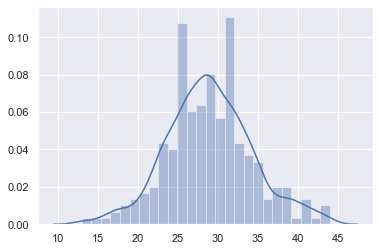

In [10]:
#Plot number of barcodes that should be 1 but are now 0
sns.distplot(dropout)
print("Average number of barcodes lost:", np.mean(dropout))

Average FPP: 0.0009127272727272728


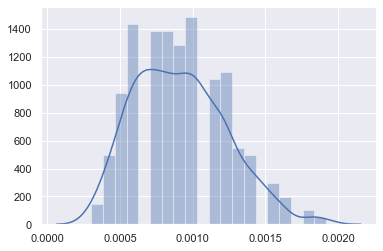

In [11]:
#Plot false positive probabilities
sns.distplot(FPPs) #, kde=False)
print("Average FPP:", np.mean(FPPs))

Average FNP: 0.00256


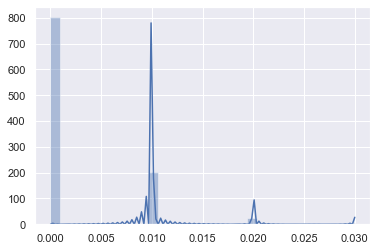

In [12]:
#Plot false negative probabilities
sns.distplot(FNPs) #, kde=False)
print("Average FNP:", np.mean(FNPs))

# Results using the Discrete Lossless Encoder

In [13]:
#Scenario 1, p=0.01
simulated = calculateerrorsparallel(0, 1000, 10000, 100, 10000, 1, 1, dsynth, dstoch, setting, mean, std, goodreads, threshold, 1)
print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average FPP:", np.mean(simulated[1]))
print("Average FNP:", np.mean(simulated[2]))


Average number of barcodes lost: 0.0
Average FPP: 0.0
Average FNP: 0.0


In [14]:
#Scenario 2, p=0.01
simulated = calculateerrorsparallel(0, 1000, 10000, 100, 10000, 5, 2, dsynth, dstoch, setting, mean, std, goodreads, threshold, 3)
print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average FPP:", np.mean(simulated[1]))
print("Average FNP:", np.mean(simulated[2]))


Average number of barcodes lost: 0.0
Average FPP: 0.0010923232323232323
Average FNP: 0.0


# Results using the Discrete Lossy Encoder

In [15]:
#Scenario 1, dsynth = 0.01, dstoch = 0.05, p = 0.01
simulated = calculateerrorsparallel(1, 1000, 10000, 100, 10000, 1, 1, 0.01, 0.05, setting, mean, std, goodreads, threshold, 1)
print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average FPP:", np.mean(simulated[1]))
print("Average FNP:", np.mean(simulated[2]))


Average number of barcodes lost: 6.496
Average FPP: 0.0
Average FNP: 0.06496


In [16]:
#Scenario 2, dsynth = 0.01, dstoch = 0.05, p = 0.01
simulated = calculateerrorsparallel(1, 1000, 10000, 100, 10000, 5, 2, 0.01, 0.05, setting, mean, std, goodreads, threshold, 3)
print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average FPP:", np.mean(simulated[1]))
print("Average FNP:", np.mean(simulated[2]))


Average number of barcodes lost: 28.996
Average FPP: 0.0009127272727272728
Average FNP: 0.0025600000000000006


# Results using the Continuous Lossless Encoder, Scenario 1

In [17]:
#Scenario 1, p = 0.01, setting = "Sat", threshold = 100
simulated = calculateerrorsparallel(2, 1000, 10000, 100, 10000, 1, 1, dsynth, dstoch, "Sat", 10000, 1000, 18000000, 100, 1)
print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average FPP:", np.mean(simulated[1]))
print("Average FNP:", np.mean(simulated[2]))


Average number of barcodes lost: 0.0
Average FPP: 0.0
Average FNP: 0.0


In [18]:
#Scenario 1, p = 0.01, setting = "Sat", threshold = 100, with bigger std
simulated = calculateerrorsparallel(2, 1000, 10000, 100, 10000, 1, 1, dsynth, dstoch, "Sat", 10000, 3000, 18000000, 100, 1)
print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average FPP:", np.mean(simulated[1]))
print("Average FNP:", np.mean(simulated[2]))


Average number of barcodes lost: 0.024
Average FPP: 0.0
Average FNP: 0.00023999999999999998


In [19]:
#Scenario 1, p = 0.01, setting = "Sat", threshold = 100, with even bigger std
simulated = calculateerrorsparallel(2, 1000, 10000, 100, 10000, 1, 1, dsynth, dstoch, "Sat", 10000, 5000, 18000000, 100, 1)
print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average FPP:", np.mean(simulated[1]))
print("Average FNP:", np.mean(simulated[2]))


Average number of barcodes lost: 2.292
Average FPP: 0.0
Average FNP: 0.022920000000000003


In [20]:
#Scenario 1, p = 0.01, setting = "Amp", threshold = 2
simulated = calculateerrorsparallel(2, 1000, 10000, 100, 10000, 1, 1, dsynth, dstoch, "Amp", 4.5, 3, 18000000, 2, 1)
print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average FPP:", np.mean(simulated[1]))
print("Average FNP:", np.mean(simulated[2]))


Average number of barcodes lost: 0.784
Average FPP: 0.0
Average FNP: 0.00784


In [21]:
#Scenario 1, p = 0.01, setting = "Amp", threshold = 10
simulated = calculateerrorsparallel(2, 1000, 10000, 100, 10000, 1, 1, dsynth, dstoch, "Amp", 4.5, 3, 18000000, 10, 1)
print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average FPP:", np.mean(simulated[1]))
print("Average FNP:", np.mean(simulated[2]))


Average number of barcodes lost: 2.693
Average FPP: 0.0
Average FNP: 0.026930000000000003


In [22]:
#Scenario 1, p = 0.01, setting = "Amp", threshold = 100
simulated = calculateerrorsparallel(2, 1000, 10000, 100, 10000, 1, 1, dsynth, dstoch, "Amp", 4.5, 3, 18000000, 100, 1)
print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average FPP:", np.mean(simulated[1]))
print("Average FNP:", np.mean(simulated[2]))


Average number of barcodes lost: 12.16
Average FPP: 0.0
Average FNP: 0.12160000000000001


# Results using the Continuous Lossless Encoder, Scenario 2

In [23]:
#Scenario 2, p = 0.01, setting = "Sat", threshold = 100
simulated = calculateerrorsparallel(2, 1000, 10000, 100, 10000, 5, 2, dsynth, dstoch, "Sat", 10000, 1000, 18000000, 100, 3)
print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average FPP:", np.mean(simulated[1]))
print("Average FNP:", np.mean(simulated[2]))


Average number of barcodes lost: 0.0
Average FPP: 0.0011028282828282826
Average FNP: 0.0


In [24]:
#Scenario 2, p = 0.01, setting = "Sat", threshold = 100, with bigger std
simulated = calculateerrorsparallel(2, 1000, 10000, 100, 10000, 5, 2, dsynth, dstoch, "Sat", 10000, 3000, 18000000, 100, 3)
print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average FPP:", np.mean(simulated[1]))
print("Average FNP:", np.mean(simulated[2]))


Average number of barcodes lost: 0.108
Average FPP: 0.0011016161616161618
Average FNP: 0.00023999999999999998


In [25]:
#Scenario 2, p = 0.01, setting = "Sat", threshold = 100, with even bigger std
simulated = calculateerrorsparallel(2, 1000, 10000, 100, 10000, 5, 2, dsynth, dstoch, "Sat", 10000, 5000, 18000000, 100, 3)
print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average FPP:", np.mean(simulated[1]))
print("Average FNP:", np.mean(simulated[2]))


Average number of barcodes lost: 11.322
Average FPP: 0.0010347474747474748
Average FNP: 0.023180000000000003


In [26]:
#Scenario 2, p = 0.01, setting = "Amp", threshold = 2
simulated = calculateerrorsparallel(2, 1000, 10000, 100, 10000, 5, 2, dsynth, dstoch, "Amp", 4.5, 3, 18000000, 2, 3)
print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average FNP:", np.mean(simulated[2]))


Average number of barcodes lost: 12.942
Average FNP: 0.02657


In [27]:
#Scenario 2, p = 0.01, setting = "Amp", threshold = 10
simulated = calculateerrorsparallel(2, 1000, 10000, 100, 10000, 5, 2, dsynth, dstoch, "Amp", 4.5, 3, 18000000, 10, 3)
print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average FPP:", np.mean(simulated[1]))
print("Average FNP:", np.mean(simulated[2]))


Average number of barcodes lost: 39.652
Average FPP: 0.0008812121212121212
Average FNP: 0.08132000000000002


In [28]:
#Scenario 2, p = 0.01, setting = "Amp", threshold = 100
simulated = calculateerrorsparallel(2, 1000, 10000, 100, 10000, 5, 2, dsynth, dstoch, "Amp", 4.5, 3, 18000000, 100, 3)
print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average FPP:", np.mean(simulated[1]))
print("Average FNP:", np.mean(simulated[2]))


Average number of barcodes lost: 122.756
Average FPP: 0.0005123232323232325
Average FNP: 0.25188000000000005


# Results using the Continuous Lossy Encoder

In [29]:
#Scenario 1, p = 0.01, setting = "Sat", threshold = 10, dsynth = 0.01, dstoch = 0.05
simulated = calculateerrorsparallel(3, 1000, 10000, 100, 10000, 1, 1, 0.01, 0.05, "Sat", 10000, 1000, 18000000, 10, 1)
print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average FPP:", np.mean(simulated[1]))
print("Average FNP:", np.mean(simulated[2]))


Average number of barcodes lost: 6.46
Average FPP: 0.0
Average FNP: 0.0646


In [30]:
#Scenario 1, p = 0.01, setting = "Amp", threshold = 10, dsynth = 0.01, dstoch = 0.05
simulated = calculateerrorsparallel(3, 1000, 10000, 100, 10000, 1, 1, 0.01, 0.05, "Amp", 4.5, 3, 18000000, 10, 1)
print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average FPP:", np.mean(simulated[1]))
print("Average FNP:", np.mean(simulated[2]))


Average number of barcodes lost: 8.852
Average FPP: 0.0
Average FNP: 0.08852000000000003


In [31]:
#Scenario 2, p = 0.01, setting = "Sat", threshold = 10, dsynth = 0.01, dstoch = 0.05
simulated = calculateerrorsparallel(3, 1000, 10000, 100, 10000, 5, 2, 0.01, 0.05, "Sat", 10000, 1000, 18000000, 10, 3)
print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average FPP:", np.mean(simulated[1]))
print("Average FNP:", np.mean(simulated[2]))


Average number of barcodes lost: 28.996
Average FPP: 0.0009263636363636364
Average FNP: 0.0026400000000000004


In [32]:
#Scenario 2, p = 0.01, setting = "Amp", threshold = 10, dsynth = 0.01, dstoch = 0.05
simulated = calculateerrorsparallel(3, 1000, 10000, 100, 10000, 5, 2, 0.01, 0.05, "Amp", 4.5, 3, 18000000, 10, 3)
print("Average number of barcodes lost:", np.mean(simulated[0]))
print("Average FPP:", np.mean(simulated[1]))
print("Average FNP:", np.mean(simulated[2]))


Average number of barcodes lost: 64.777
Average FPP: 0.0007516161616161616
Average FNP: 0.08075000000000002
